Starting ecosystem analysis...
Total simulations: 10
Expected total species data: ~20000

=== Processing beta = 1.826 (1/1) ===
Run 1/10 Extinction rate: 0.000, Survivors: 4000
Abundance range: 1.00e+00 to 7.18e+01
Species in [1, 10): 3925
Species in [10, 100): 75
Species in [100, 1000): 0
Species >= 1000: 0
Average points per log decade: 2154.8
✓ 4000 survivors
Run 2/10 Extinction rate: 0.000, Survivors: 4000
✓ 4000 survivors
Run 3/10 Extinction rate: 0.000, Survivors: 4000
✓ 4000 survivors
Run 4/10 Extinction rate: 0.000, Survivors: 4000
✓ 4000 survivors
Run 5/10 ✗ Integration failed
Run 6/10 Extinction rate: 0.000, Survivors: 4000
✓ 4000 survivors
Run 7/10 Extinction rate: 0.000, Survivors: 4000
✓ 4000 survivors
Run 8/10 Extinction rate: 0.000, Survivors: 4000
✓ 4000 survivors
Run 9/10 Extinction rate: 0.000, Survivors: 4000
✓ 4000 survivors
Run 10/10 Extinction rate: 0.000, Survivors: 4000
✓ 4000 survivors

Beta 1.826 summary:
Successful runs: 9/10
Total surviving species: 36000
Ab

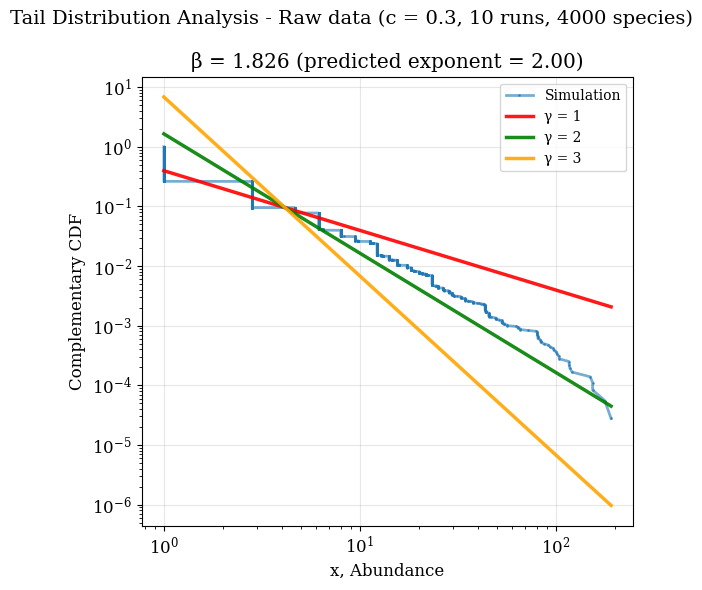


2. Log-binned data (smoother representation):
Analysis complete!


<Figure size 640x480 with 0 Axes>

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from scipy.stats import poisson
import warnings
warnings.filterwarnings('ignore')

class EcosystemAnalyzer:
    """
    Analyzes the tail distribution of stationary states in ecological models
    """
    
    def __init__(self, S=5000, runs=50, tmax=500, delta=0.3):
        """
        Initialize the analyzer with model parameters
        
        Parameters:
        -----------
        S : int
            Number of species
        runs : int
            Number of simulation runs
        tmax : int
            Maximum time for integration
        delta : float
            Connection probability parameter
        """
        self.S = S
        self.runs = runs
        self.tmax = tmax
        self.delta = delta
        self.survival_threshold = 1e-6
        
    def ecosystem_dynamics(self, t, x, alpha, system='glv'):
        """
        Define the ecosystem dynamics for different model types
        
        Parameters:
        -----------
        t : float
            Time (not used in autonomous systems)
        x : array
            Population abundances
        alpha : array
            Interaction matrix
        system : str
            Type of dynamics ('linear', 'glv', 'linsat', 'glvsat', 'glv_carcap')
        """
        # Ensure non-negative populations
        x = np.maximum(x, 0)
        
        if system == 'linear':
            return (1 - x + np.dot(alpha, x)) + 1e-10
        elif system == 'glv':  # Generalized Lotka-Volterra
            return x * (1 - x + np.dot(alpha, x)) + 1e-10
        elif system == 'linsat':
            return (1 - x + np.dot(alpha, x/(1+x))) + 1e-10
        elif system == 'glvsat':
            return x * (1 - x + np.dot(alpha, x/(1+x))) + 1e-10
        elif system == 'glv_carcap':
            return x * (1 - 3*x + np.dot(alpha, x)) + 1e-10
        else:
            raise ValueError(f"Unknown system type: {system}")
    
    def solve_dynamics(self, initial_conditions, interactions, system='glv', dt=1):
        """
        Solve the ecosystem dynamics using scipy's ODE solver
        
        Parameters:
        -----------
        initial_conditions : array
            Initial population abundances
        interactions : array
            Interaction matrix
        system : str
            Type of dynamics
        dt : float
            Time step for output
            
        Returns:
        --------
        array
            Solution trajectory
        """
        t_eval = np.arange(0, self.tmax, dt)
        
        try:
            sol = scipy.integrate.solve_ivp(
                self.ecosystem_dynamics, 
                [0, self.tmax], 
                initial_conditions,
                args=[interactions, system], 
                method='LSODA',
                t_eval=t_eval,
                rtol=1e-8,
                atol=1e-10
            )
            return sol.y
        except Exception as e:
            print(f"Integration failed: {e}")
            return np.array([])
    
    def extract_survivors(self, final_state, debug=False):
        """
        Extract surviving species from final state
        
        Parameters:
        -----------
        final_state : array
            Final population abundances
        debug : bool
            Print diagnostic information
            
        Returns:
        --------
        list
            Abundances of surviving species
        """
        survivors = []
        extinct_count = 0
        
        for abundance in final_state:
            if (abundance > self.survival_threshold and 
                abundance < 1e100 and 
                not np.isnan(abundance)):
                survivors.append(abundance)
            else:
                extinct_count += 1
        
        extinction_rate = extinct_count / len(final_state)
        print(f"Extinction rate: {extinction_rate:.3f}, Survivors: {len(survivors)}")
        
        if debug and len(survivors) > 0:
            survivors_sorted = np.sort(survivors)
            print(f"Abundance range: {survivors_sorted[0]:.2e} to {survivors_sorted[-1]:.2e}")
            
            # Analyze distribution across decades
            decades = [1, 10, 100, 1000]
            for i in range(len(decades)-1):
                count = np.sum((survivors_sorted >= decades[i]) & (survivors_sorted < decades[i+1]))
                print(f"Species in [{decades[i]}, {decades[i+1]}): {count}")
            
            # Count species above 1000
            high_count = np.sum(survivors_sorted >= 1000)
            print(f"Species >= 1000: {high_count}")
            
            # Check density in log space
            log_abundances = np.log10(survivors_sorted)
            log_range = np.max(log_abundances) - np.min(log_abundances)
            density = len(survivors_sorted) / log_range
            print(f"Average points per log decade: {density:.1f}")
        
        return survivors
    
    def smooth_ccdf(self, data, method='binning', n_bins=50, window_size=10):
        """
        Smooth the CCDF to reduce noise using various methods
        
        Parameters:
        -----------
        data : list
            Abundance data
        method : str
            Smoothing method ('binning', 'moving_average', 'log_binning')
        n_bins : int
            Number of bins for binning methods
        window_size : int
            Window size for moving average
            
        Returns:
        --------
        tuple
            (smoothed_ccdf, smoothed_abundances)
        """
        if not data or len(data) < 10:
            return np.array([]), np.array([])
        
        sorted_data = np.sort(data)
        
        if method == 'binning':
            # Equal-width binning in linear space
            bins = np.linspace(np.min(sorted_data), np.max(sorted_data), n_bins)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            
            ccdf_smooth = np.zeros(len(bin_centers))
            for i, center in enumerate(bin_centers):
                ccdf_smooth[i] = np.mean(sorted_data > center)
                
            return ccdf_smooth, bin_centers
            
        elif method == 'log_binning':
            # Log-spaced binning (better for power-law data)
            if np.min(sorted_data) <= 0:
                sorted_data = sorted_data[sorted_data > np.min(sorted_data[sorted_data > 0])]
            
            log_min = np.log10(np.min(sorted_data))
            log_max = np.log10(np.max(sorted_data))
            log_bins = np.logspace(log_min, log_max, n_bins)
            bin_centers = np.sqrt(log_bins[:-1] * log_bins[1:])  # Geometric mean
            
            ccdf_smooth = np.zeros(len(bin_centers))
            for i, center in enumerate(bin_centers):
                ccdf_smooth[i] = np.mean(sorted_data > center)
                
            return ccdf_smooth, bin_centers
            
        elif method == 'moving_average':
            # Moving average smoothing
            ccdf_values = 1 - np.arange(len(sorted_data)) / len(sorted_data)
            
            # Apply moving average
            smoothed_ccdf = np.convolve(ccdf_values, 
                                      np.ones(window_size)/window_size, 
                                      mode='valid')
            smoothed_abundances = sorted_data[window_size//2:len(smoothed_ccdf)+window_size//2]
            
            return smoothed_ccdf, smoothed_abundances
        
        else:
            raise ValueError(f"Unknown smoothing method: {method}")
    
    def compute_ccdf(self, data):
        """
        Compute the complementary cumulative distribution function (CCDF)
        
        Parameters:
        -----------
        data : list
            Abundance data
            
        Returns:
        --------
        tuple
            (ccdf_values, sorted_data)
        """
        if not data:
            return np.array([]), np.array([])
            
        sorted_data = np.sort(data)
        # Complementary CDF: P(X > x)
        ccdf_values = 1 - np.arange(len(data)) / len(data)
        
        return ccdf_values, sorted_data
    
    def generate_interaction_matrix(self, beta):
        """
        Generate random interaction matrix with Poisson-distributed interactions
        
        Parameters:
        -----------
        beta : float
            Interaction strength scaling
            
        Returns:
        --------
        array
            Interaction matrix
        """
        # Generate Poisson-distributed interactions
        interactions = beta * poisson.rvs(self.delta/self.S, size=[self.S, self.S])
        
        # Set diagonal to zero (no self-interaction in this formulation)
        np.fill_diagonal(interactions, 0)
        
        return interactions
    
    def compute_ccdf(self, data):
        """
        Compute the complementary cumulative distribution function (CCDF)
        
        Parameters:
        -----------
        data : list
            Abundance data
            
        Returns:
        --------
        tuple
            (ccdf_values, sorted_data)
        """
        if len(data) == 0:
            return np.array([]), np.array([])
            
        sorted_data = np.sort(data)
        # Complementary CDF: P(X > x)
        ccdf_values = 1 - np.arange(len(data)) / len(data)
        
        return ccdf_values, sorted_data
    
    def run_analysis(self, betas, system='glv'):
        """
        Run the full analysis for different beta values
        
        Parameters:
        -----------
        betas : list
            List of beta values to analyze
        system : str
            Type of dynamics
            
        Returns:
        --------
        tuple
            (abundance_data, ccdf_data) for each beta
        """
        all_abundances = []
        all_ccdfs = []
        
        for i, beta in enumerate(betas):
            print(f"\n=== Processing beta = {beta:.3f} ({i+1}/{len(betas)}) ===")
            
            combined_data = []
            successful_runs = 0
            
            for run in range(self.runs):
                print(f"Run {run+1}/{self.runs}", end=" ")
                
                # Generate interaction matrix
                interactions = self.generate_interaction_matrix(beta)
                
                # Random initial conditions
                initial_conditions = np.random.rand(self.S)
                
                # Solve dynamics
                solution = self.solve_dynamics(initial_conditions, interactions, system)
                
                if solution.size > 0 and solution.shape == (self.S, self.tmax):
                    # Extract survivors from final state
                    final_state = solution[:, -1]
                    survivors = self.extract_survivors(final_state, debug=(run==0))
                    combined_data.extend(survivors)
                    successful_runs += 1
                    
                    print(f"✓ {len(survivors)} survivors")
                else:
                    print("✗ Integration failed")
            
            print(f"\nBeta {beta:.3f} summary:")
            print(f"Successful runs: {successful_runs}/{self.runs}")
            print(f"Total surviving species: {len(combined_data)}")
            
            if len(combined_data) > 0:
                # Analyze abundance distribution
                combined_sorted = np.sort(combined_data)
                print(f"Abundance range: {combined_sorted[0]:.2e} to {combined_sorted[-1]:.2e}")
                
                # Check coverage across decades
                decades = [1, 10, 100, 1000, 10000]
                print("Distribution across abundance ranges:")
                for j in range(len(decades)-1):
                    count = np.sum((combined_sorted >= decades[j]) & (combined_sorted < decades[j+1]))
                    percentage = 100 * count / len(combined_sorted)
                    print(f"  [{decades[j]}, {decades[j+1]}): {count} species ({percentage:.1f}%)")
                
                # Compute both raw and binned CCDF
                ccdf_values, sorted_abundances = self.compute_ccdf(combined_data)
                
                all_abundances.append(sorted_abundances)
                all_ccdfs.append(ccdf_values)
            else:
                all_abundances.append(np.array([]))
                all_ccdfs.append(np.array([]))
        
        return all_abundances, all_ccdfs
    
    def plot_results(self, betas, abundances, ccdfs,preds, use_binning=True):
        """
        Plot the results with theoretical predictions on separate subplots
        Focus on tail alignment for better comparison
        
        Parameters:
        -----------
        betas : list
            Beta values used
        abundances : list
            Abundance data for each beta
        ccdfs : list
            CCDF data for each beta
        use_binning : bool
            Whether to use log binning for smoother curves
        """
        # Set up plotting parameters
        plt.rcParams.update({
            "font.size": 12,
            "font.family": "serif",
            "mathtext.fontset": "cm",
        })
        
        # Create subplots - one for each beta
        n_betas = len([i for i, beta in enumerate(betas) 
                      if len(abundances[i]) > 0 and len(ccdfs[i]) > 0])
        
        if n_betas == 0:
            print("No valid data to plot!")
            return
            
        fig, axes = plt.subplots(1, n_betas, figsize=(6*n_betas, 6))
        if n_betas == 1:
            axes = [axes]  # Make it iterable
        
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        
        plot_idx = 0
        for i, beta in enumerate(betas):
            if len(abundances[i]) == 0 or len(ccdfs[i]) == 0:
                continue
                
            ax = axes[plot_idx]
            
            if use_binning:
                # Use log binning for smoother representation
                y_data, x_data = self.create_log_binned_ccdf(abundances[i], n_bins_per_decade=15)
                plot_style = 'o-'
                markersize = 4
                alpha = 0.8
                label_suffix = ' (binned)'
            else:
                # Use raw data
                x_data = abundances[i]
                y_data = ccdfs[i]
                plot_style = 'o-'
                markersize = 1
                alpha = 0.6
                label_suffix = ' (raw)'
            
            # Remove zeros and invalid values for log plot
            valid_mask = (x_data > 0) & (y_data > 0) & np.isfinite(x_data) & np.isfinite(y_data)
            x_data = x_data[valid_mask]
            y_data = y_data[valid_mask]
            
            if len(x_data) == 0:
                continue
            
            print(f"Beta {beta:.3f}: Plotting {len(x_data)} points")
            
            # Plot the data
            ax.loglog(x_data, y_data, plot_style, alpha=alpha, 
                     color=colors[plot_idx % len(colors)],
                     label=f'Simulation', 
                     markersize=markersize, linewidth=2)
            
            # Theoretical predictions
            p = -np.log(self.delta) / np.log(beta)
            print(f"Beta: {beta:.3f}, Theoretical exponent: {p:.2f}")
            
            # Generate theoretical curves over the data range
            x_theory = np.logspace(np.log10(np.min(x_data)), 
                                 np.log10(np.max(x_data)), 100)
            
            # Different theoretical predictions
            exponents = preds[i]
            theory_colors = ['red', 'green', 'orange']
            linestyles = ['-', '-', '-']
            
            # Align theories to the tail region (upper third of abundance range)
            tail_mask = x_data > np.percentile(x_data, 67)
            if np.sum(tail_mask) > 3:
                # Use geometric mean of tail region for alignment
                x_ref = np.exp(np.mean(np.log(x_data[tail_mask])))
                y_ref = np.interp(x_ref, x_data, y_data)
                
                print(f"Aligning theories at x_ref = {x_ref:.3e}, y_ref = {y_ref:.3e}")
                
                for j, (exp, color, style) in enumerate(zip(exponents, theory_colors, linestyles)):
                    y_theory = x_theory**(-exp)
                    # Normalize at reference point in tail
                    y_ref_theory = x_ref**(-exp)
                    scale_factor = y_ref / y_ref_theory
                    y_theory_scaled = y_theory * scale_factor
                    
                    ax.loglog(x_theory, y_theory_scaled, 
                             linestyle=style, color=color, alpha=0.9,
                             linewidth=2.5, label=f'γ = {exp}')
            else:
                # Fallback to median alignment
                mid_idx = len(x_data) // 2
                x_ref = x_data[mid_idx]
                y_ref = y_data[mid_idx]
                
                for j, (exp, color, style) in enumerate(zip(exponents, theory_colors, linestyles)):
                    y_theory = x_theory**(-exp)
                    y_ref_theory = x_ref**(-exp)
                    scale_factor = y_ref / y_ref_theory
                    y_theory_scaled = y_theory * scale_factor
                    
                    ax.loglog(x_theory, y_theory_scaled, 
                             linestyle=style, color=color, alpha=0.8,
                             linewidth=2, label=f'{exp}')
            
            ax.set_xlabel('x, Abundance')
            ax.set_ylabel('Complementary CDF')
            ax.set_title(f'β = {beta:.3f} (predicted exponent = {p:.2f})')
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)
            
            plot_idx += 1
    
        method_str = "Log-binned" if use_binning else "Raw data"
        plt.suptitle(f'Tail Distribution Analysis - {method_str} (c = {self.delta}, '
                    f'{self.runs} runs, {self.S} species)', fontsize=14)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'./ecosystem_tail_distribution_{"binned" if use_binning else "raw"}.png', dpi=300)

# Main execution
def main():
    # Model parameters - increased for better coverage
    S = 4000          # Species per simulation (5x original)
    runs = 10         # Simulation runs (5x original)  
    tmax = 500        # Integration time
    delta = 0.3       # Connection parameter
    
    # Beta values to analyze (interaction strengths)
    betas = [ delta**(-1/2)]
    preds = [[1,2,3]]  # Theoretical predictions for each beta

    # Create analyzer
    analyzer = EcosystemAnalyzer(S=S, runs=runs, tmax=tmax, delta=delta)
    
    # Run analysis
    print("Starting ecosystem analysis...")
    print(f"Total simulations: {len(betas) * runs}")
    print(f"Expected total species data: ~{len(betas) * runs * S // 2}")  # Rough estimate
    
    abundances, ccdfs = analyzer.run_analysis(betas, system='glv')
    
    # Plot results with both raw and binned versions
    print("\n" + "="*50)
    print("PLOTTING RESULTS")
    print("="*50)

    print("\n1. Raw data (showing discrete nature):")
    analyzer.plot_results(betas, abundances, ccdfs, preds,use_binning=False)
    
    print("\n2. Log-binned data (smoother representation):")
    #analyzer.plot_results(betas, abundances, ccdfs,preds, use_binning=True)
    
    #np.to_csv("abundances.csv", abundances)
    #np.to_csv("ccdfs.csv", ccdfs)
    print("Analysis complete!")

main()